# YOLO v4

- YOLO v4 = YOLO v3 + CSPDarknet53(backbone) + SPP + PAN + BoF + BoS

## 1. BoF (Bag of Freebies)

- Inference 시간은 늘리지 않으면서 더 높은 정확도를 얻기 위해 학습 시키는 방법들
  - Data Augmentation, Regularization, Loss Function 등

### 1-1. Data Augmentation

- 입력 이미지에 변동성을 높여 설계된 모델이 다른 환경에서 얻은 이미지에 보다 Robust해 질 수 있도록 하기 위해서 수행
  - Robust하다 : 다소 다른 특성의 이미지가 와도 민감하게 반응하지 않는다

- v4에서는 Pixel-wise adjustment, Simulating object occlusion(Random Erase, CutOut), Using multiple images(Mosaic, MixUp, CutMix), Style transfer GAN 등을 사용
  - 이 중, CutMix는 Classifiaction 문제에서 효과가 좋았고, Mosaic은 Classification에서도 Object Detection에서도 효과가 좋았다

< CutOut >

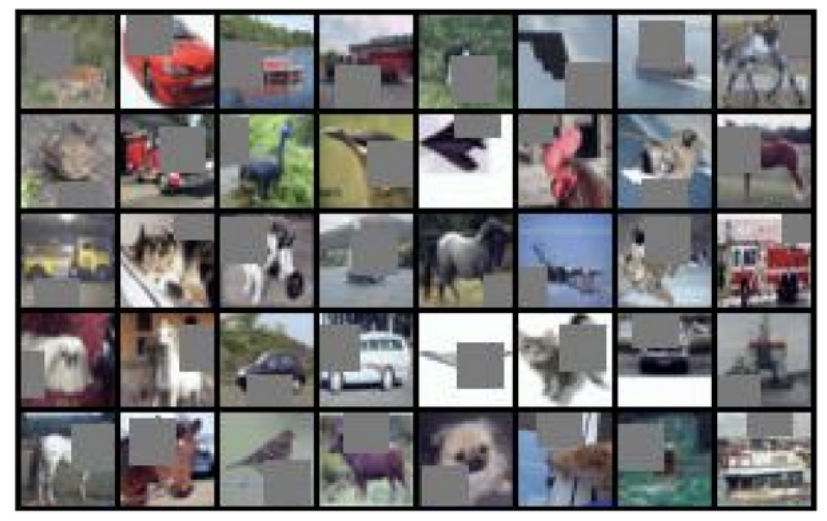

< MixUp >

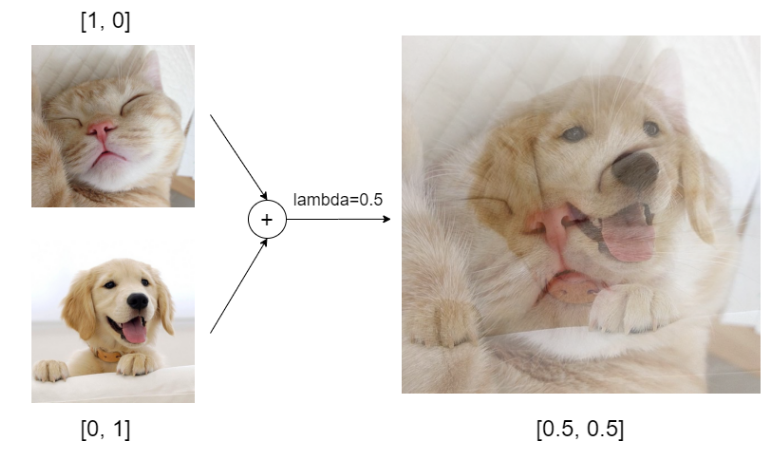

< MOSAIC >


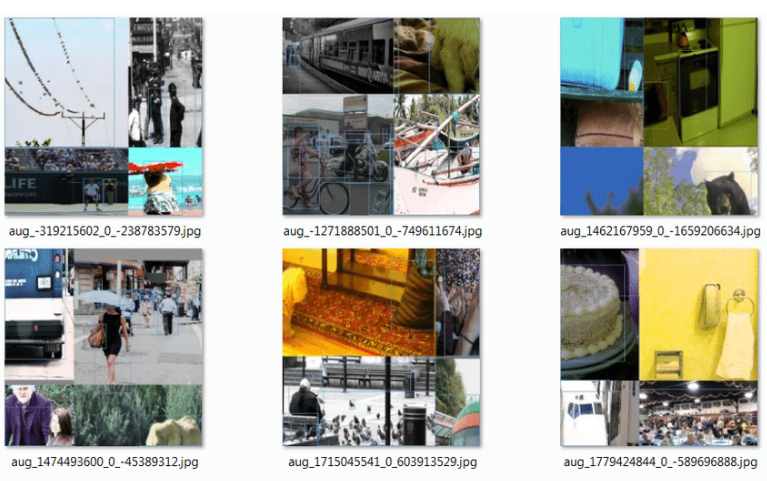

### 1-2. Sementic Distribution Bias

- 학습 데이터셋 자체에 내재하는 편향(클래스간 불균형 등)을 해결하기 위해 도입

< 배경과 객체 문제 >

- 대부분의 이미지는 물체가 차지하는 영역보다 배경이 차지하는 영역이 훨씬 많고, 이로 인해 클래스간 불균형 문제가 발생한다.
- R-CNN 계열인 Two-Stage OD에서는 이를 해결하는 기법들이 있지만, One-Stage OD에는 맞지 않는다
  - YOLO v4에서는 Focal Loss로 해결한다
    - OD 문제에서 배경은 객체에 비해 Detector에 의해 잘 분류될 수 있어서 loss가 작으나, 그 수가 굉장히 많기 때문에 전체 loss 및 gradient를 계산할 때는 영향이 압도적으로 커지는 문제가 발생
    - 이 때, Loss를 기존의 Cross-entropy가 아닌 Focal Loss라는 새로운 식을 도입하여 주면 이 문제가 개선됨


< 카테고리 간 연관성 >

- 서로 다른 카테고리 간의 연관성을 표현하기 위해 Label refinement network 활용
  - 고양이라는 카테고리에 대해 [ 고양이:1, 강아지:0, 사람:0 ] 이라 labeling하는 것이 아니라 [ 고양이:0.9, 강아지:0.1, 사람:0 ]으로 표현
  - 보다 Robust한 모델에 도움

### 1-3. BBox Loss Function

- Bouding Box의 Loss Function으로 기존의 MSE(L2 Loss) 외에 IoU기반의 Loss Function(GIoU, CIoU, DIoU 등)들을 실험
  - 실험 결과도 MSE보다 IoU 기반 Loss들이 성능이 좋았고, 최종 CIoU를 사용

### 1-4. Regularization method

- 오버피팅을 막기 위한 regularization 기법으로는 DropOut, DropPath, Spatial DropOut, DropBlock 등이 있으며 그 중 **DropBlock**을 적용했을 때 성능이 가장 좋다

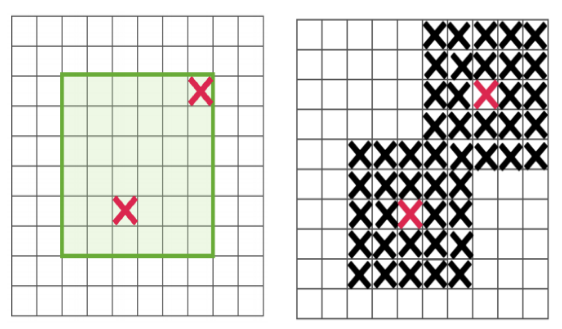

#### DropBlock

- 일반적인 Dropout의 단점은 Feature를 무작위로 drop하는 것.
  - 전연결층에서는 효과적일 수 있지만, 형상이 공간적으로 상관되어있는 Convolutional layer에서는 효과적이지 않음

- DropBlock은 무작위로 drop하는 것이 아니라 피처의 일정 범위를 함께 drop하는 것

- 샘플링된 각 항목이 Feature map 안에 완전히 포함된 Mask로 확장될 수 있는 녹색 영역에서만 Mask를 샘플링

## BoS ( Bag of Specials )

- Inference 시간은 아주 조금 증가시키지만, 정확도는 크게 향상시키는 방법

### 2-1. Enhance receptive field

- backbone에서 얻은 feature map에 대한 receptive field를 키우는 방법
  - SPP(Spatial Pyramid Pooling) / ASPP(Atrous SPP) / RFB(Receptive Field Block Net) 등
  - 이 중 **SPP**를 사용 (**3-2.Neck**에서 자세한 설명)

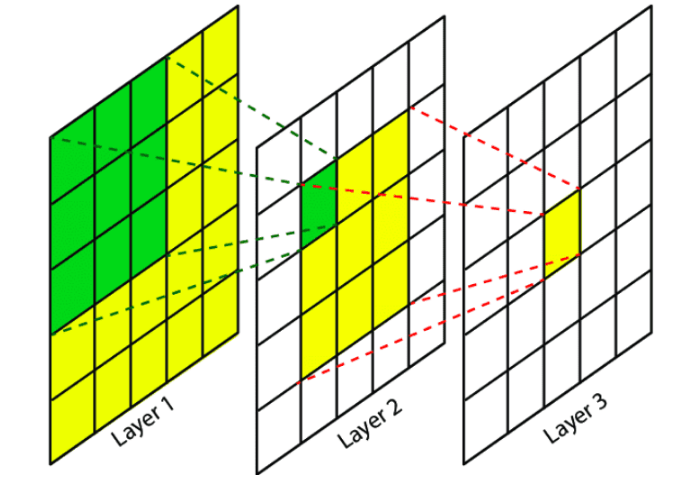

- receptive field란 feature를 생성하는 input 영역의 크기
- 위 이미지에서 3 x 3 CNN filter를 적용했다고 할 때, Layer2의 초록색 영역의 receptive field는 Layer1 의 초록색 영역

### 2-2. Post-processing Method

- 후처리 중 같은 객체를 예측하는 BBox를 제거하는 NMS도 발전을 시켜 DIoU NMS를 사용

#### DIoU NMS

- 기존의 IoU NMS는 박스간 겹치는 영역만 계산에 사용하여 NMS 진행
- DIoU는 박스간 중심점의 거리도 고려하여 NMS 진행

## Model Architecture

### 3-1. Backbone

- YOLO v4의 Backbone으로 CSPDarknet53 모델을 사용
  1. 작은 물체를 잘 예측하기 위해 Input Resolution을 크게 사용할 수 있고
  2. BoS에서 했던 노력처럼 Receptive Field를 키워주기 위해 깊은 Layer를 쌓고,
  3. 모델 성능을 위해 파라미터 수를 키움
  4. 그럼에도 Inference 속도가 빠름


#### CSPNet

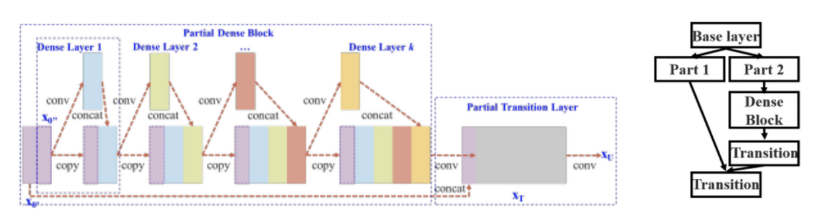

- Input feature map을 두 파트로 나눠서 한 파트는 아무 연산도 하지 않고 전달만 하고, 나머지 파트만 연산에 참여한 후 다시 합쳐줌
  - 정확도에 손실이 없으면서 연산은 빠르게 수행할 수 있다

- 이 CSP Layer를 Darknet53에 연결하여 Backbone으로 사용

### 3-2. Neck

#### SPP (Spatial Pyramid Pooling)

- Receptive Field를 늘리기 위한 방법 중 하나
  - Feature map을 정해준 grid에 맞추어 max pooling

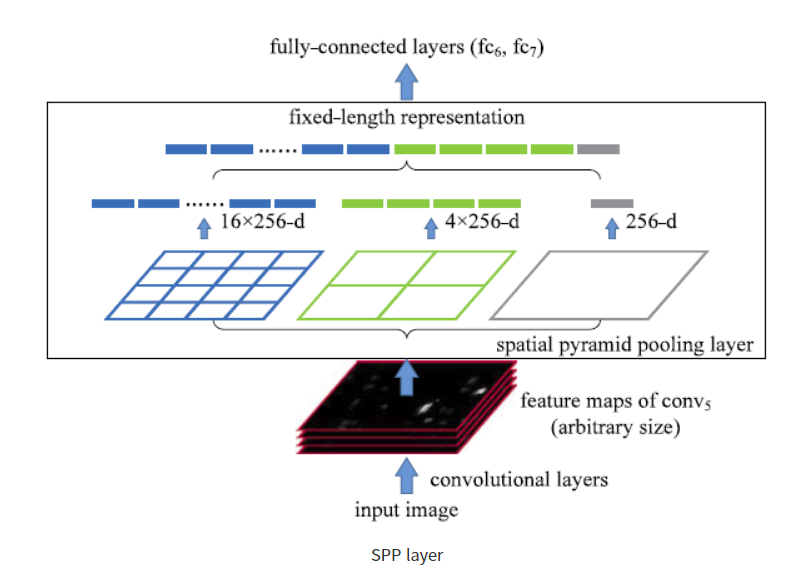

- 가장 왼쪽 Pooling Layer는 feature map을 4 x 4로 나누어 각 grid cell 별로 max pooling하여 한 줄로 flat
- 가운데 Pooling Layer는 2 x 2로 영역을 나누어 pooling하여 한 줄로 flat
- 마지막 layer는 전체를 한 값으로 Pooling

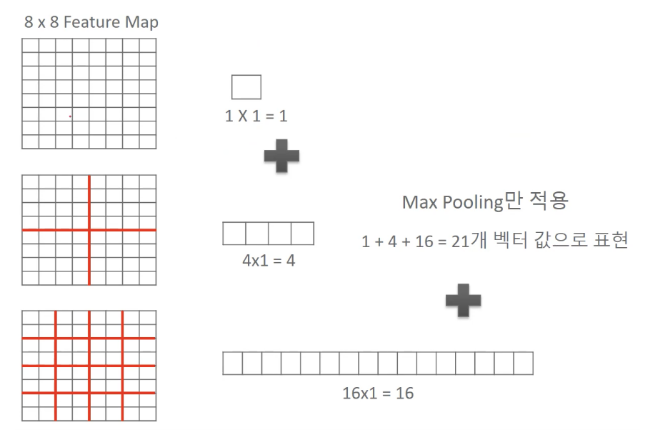

- YOLO에서는 5 x 5 / 9 x 9 / 13 x 13 size가 적용
  - Input으로 어떤 size가 들어오든 일정한 개수의 값을 return하기 때문에 Input image의 size를 자유롭게 넣어줄 수 있다

#### Path-aggregation blocks : PANet

- 기존 YOLO v3의 FPN(Feature Pyramid Networks)가 아닌 PAN(PAth Augmented Network)를 사용

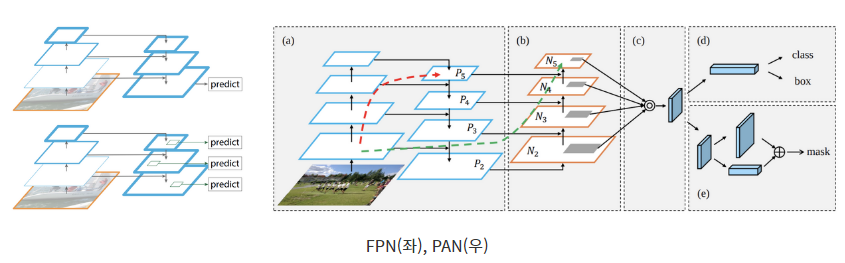

- 일반적으로 low-level feature는 작은 객체를, high-level feature는 큰 객체를 검출하는데 유용하다
- 하지만, 작은 객체를 포착하는데 highj-level feature도 필요하고, 큰 객체를 포착하는데 low-level feature도 분명히 필요
  - low-level과 high-level 정보를 풍부하게 활용하면 더 정확한 localization이 가능
---
- 기존의 FPN은 최하단 Layer가 최상단에 도달할 때까지 100 layer 이상을 거쳐야 한다 (오른쪽 이미지의 빨간색 점선)
- PAN은 FPN이 생성한 [P2,P3,P4,P5]를 활용하여 [N2,N3,N4,N5]를 생성
  - 최하단 Layer가 최상단에 도달하기까지 몇개의 Layer만 거치면 됨 (오른쪽 이미지의 녹색 점선)
  - low-level의 정보가 온전히 high-level에 전달되어 활용할 수 있다.

### 3-3. Head

- Head는 기존 YOLO v3와 같이 3 Scale로 prediction

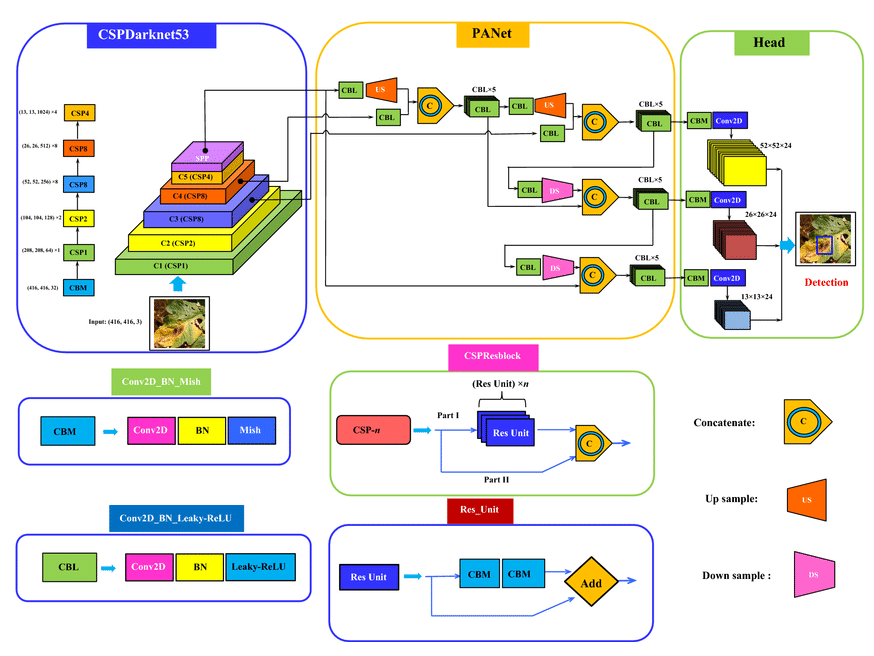

Input Image를 입력받고 -> Backbone -> SPP Layer -> PANet -> Head를 거쳐 Detection 결과가 리턴

# YOLO v5, v6

- YOLO v5는 v4가 공개된 지 2달만인 2020년 6월에 공개
  - 논문도, Tech Report도 아닌 코드만 공개
  - v3를 Pytorch로 구현했던 사람이 본인 Github에 코드를, 블로그에는 성능 등 간략한 내용만 공개한 것
    - 따라서 어디에도 이전 version들에 비해 성능 외 어떤 점이 달라졌는지 구체적으로 명시된 내용이 없다.
    - 또한, 처음에는 Version5로 공개했지만, 2021년 10월에 모델 구조를 조금 바꾸어 Version6로 업데이트 되었다

## 1. Backbone

- 기존에는 C언어로 구현된 Darknet을 사용했지만, YOLO v5부터는 Pytorch로 구현
- Head에 Neck 부분이 같이 있고 마지막 Detect Layer가 실제 Head를 담당

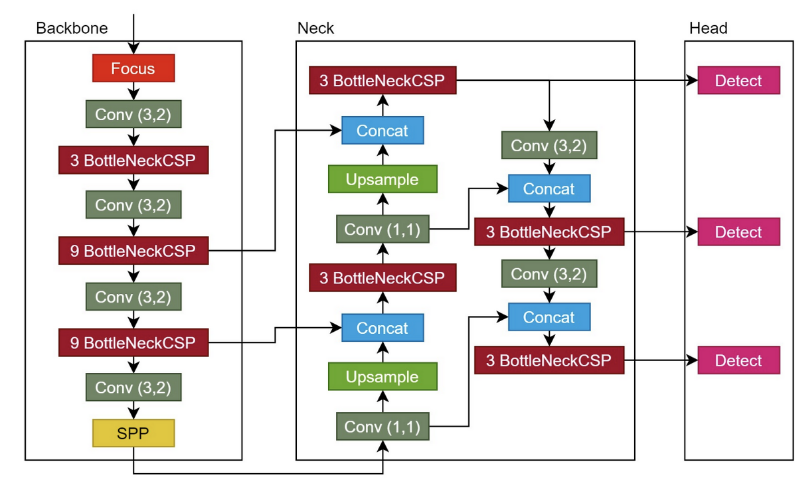

1. Focus( )가 일반 Conv Layer로 대체
  - 기존의 Focus( ) Layer는 input을 받아 Depth를 늘려주는 역할
  - ex) [1,1,4,4] -> [1,4,2,2] = [N,C,W,H]
  - 이 때, kernel size가 3인 Focus Layer와 kernel size가 6이고 Stride가 2인 Conv Layer가 동일한 결과를 낸다는 것이 밝혀져 수정됨

2. 기존의 SPP Layer와 수학적으로 동일한 결과를 내면서 속도는 더 빠른 SPPF Layer를 사용

3. Model을 더 깊게 쌓기 위해 Bottleneck CSP Layer를 반복하는 구조로 짜여짐

# 총정리

- YOLO v2부터 Anchor BOx가 도입되었으며, K-means로 Optimal한 크기와 개수를 정해준다
- v2부터 FC Layer가 사라져, 다양한 Size의 Input을 넣을 수 있게 되었다
- YOLO의 고질적인 문제인 Small Object를 잘 못 찾는다는 문제점은 v3에서 3 scale로 예측하면서 크게 해소되었다
- v4부터 Moaic, MixUp 등 다양한 Augmentation을 적용하여 성능을 향상시켰다
- v4는 CSP Layer를 활용하여 정확도는 향상시키되, 속도는 줄이는데 큰 역할을 했다
- v4까지는 Darknet 기반 Backbone을 사용했으나, v5부터 Pytorch로 구현된 Backbone을 사용한다
- v6부터는 기존 3개 Scale로 Detection하던 것에서 4개로 늘어 더 다양한 Size의 Object를 잘 Detection한다